In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from utils import llava_load_model, llava_process_image, llava_generate
from lens_utils import llava_logit_lens

##### Constants

In [4]:
project_dir = "/root/vlm-compositionality"

dataset_folder = project_dir+"/data/raw/sugarcrepe",
image_folder = project_dir+"/data/raw/coco"
model_name = "llava-hf/llava-1.5-7b-hf"
#image_file = image_folder+"/val2017/000000008690.jpg"
image_file = image_folder+"/val2014/COCO_val2014_000000562150.jpg"

num_patches = 24

##### Load image

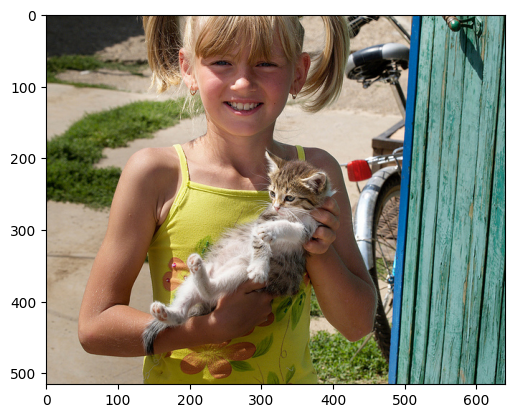

In [5]:
# load image
image = Image.open(image_file).convert("RGB")
plt.imshow(image)

##### Load model

In [6]:
# load model, processor
model, processor = llava_load_model(model_name) #, flash_attention=False, torch_dtype=torch.float32)

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.62M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

##### Process inputs

In [7]:
# process image and prompt(default)
inputs = llava_process_image(image, processor, device=model.device)

##### Get hidden states

In [8]:
# generate
outputs = llava_generate(inputs, model)

Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.50.
From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


##### Get logit lens

In [51]:
# vocab_dim, num_layers, num_tokens
# TODO: what are the tokens?
softmax_probs = llava_logit_lens(inputs, model, outputs, topk=5)

##### Object

In [52]:
class_ = 'cat'
class_token_indices = processor.tokenizer.encode(class_)[1:]

#### Internal confidence heatmap

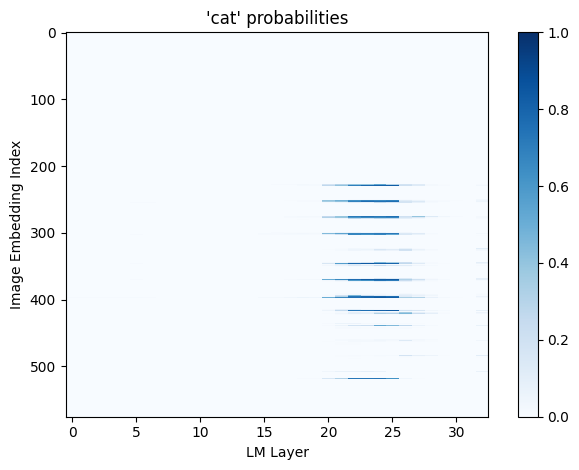

In [53]:
heatmap_data = softmax_probs[class_token_indices].max(axis=0).T
num_image_embeddings = softmax_probs.shape[2]
im = plt.imshow(heatmap_data, aspect=30/num_image_embeddings, cmap='Blues', interpolation='nearest')
plt.title(f"'{class_}' probabilities")
plt.xlabel("LM Layer")
plt.ylabel("Image Embedding Index")
plt.tight_layout()
plt.clim(0, 1)
plt.colorbar()
plt.show()

##### Localization

In [54]:
def viz_localization(softmax_probs, class_token_indices, image, layer=None):

    img_width, img_height = image.size

    if layer is None:
        softmax_probs = softmax_probs[class_token_indices].max(axis=0).max(axis=0)
    else:
        softmax_probs = softmax_probs[class_token_indices].max(axis=0)[layer]
    segmentation = softmax_probs.reshape(num_patches, num_patches).astype(float)

    # TODO: other interpolation methods apart from Image.BILINEAR
    segmentation_resized = (np.array(Image.fromarray(segmentation).resize((img_width, img_height), Image.BILINEAR)))
    plt.imshow(image)
    plt.imshow(segmentation_resized, cmap='jet', interpolation='bilinear', alpha=.5)
    plt.axis('off')
    # TODO: layer in title
    plt.title(f"'{class_},' localization")
    plt.tight_layout()
    plt.show()

##### Max localization

/tmp/ipykernel_1026/2801105813.py:12: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  segmentation_resized = (np.array(Image.fromarray(segmentation).resize((img_width, img_height), Image.BILINEAR)))


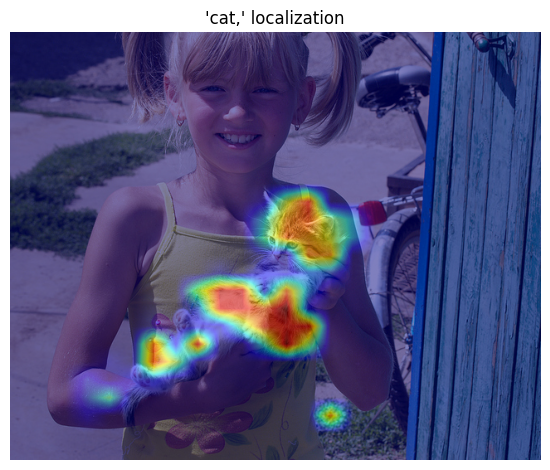

In [55]:
viz_localization(softmax_probs, class_token_indices, image)

##### Localization by layer

In [ ]:
viz_localization(softmax_probs, class_token_indices, image, 25)

##### Localization evaluation

In [48]:
img_width, img_height = image.size

softmax_probs = softmax_probs[class_token_indices].max(axis=0).max(axis=0)
segmentation = softmax_probs.reshape(num_patches, num_patches).astype(float)

segmentation_resized = (np.array(Image.fromarray(segmentation).resize((img_width, img_height), Image.BILINEAR)))

/tmp/ipykernel_1026/2759490495.py:6: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  segmentation_resized = (np.array(Image.fromarray(segmentation).resize((img_width, img_height), Image.BILINEAR)))


In [49]:
non_zeros = np.nonzero(segmentation_resized)
mask = np.zeros(segmentation_resized.shape)
for l in range(len(non_zeros[0])):
    i = non_zeros[0][l]
    j = non_zeros[1][l]
    mask[i,j] = 1

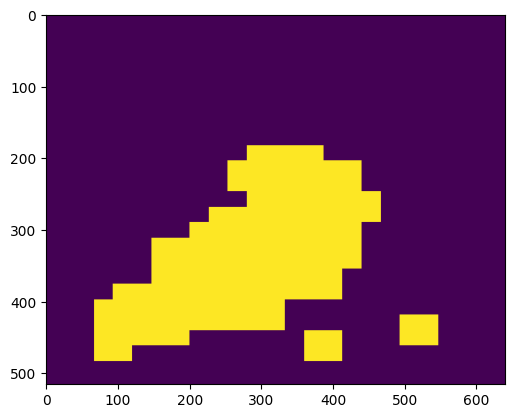

In [16]:
# TODO: how does topk change mask?
plt.imshow(mask) # 50

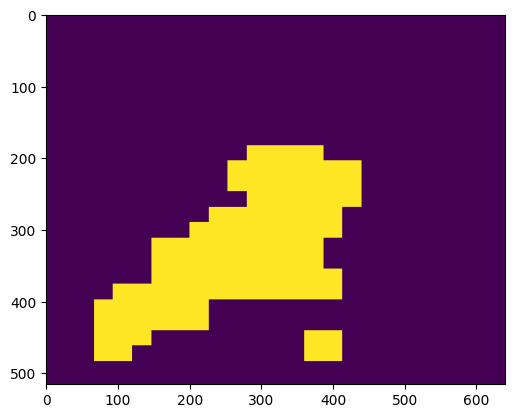

In [20]:
plt.imshow(mask) # 10

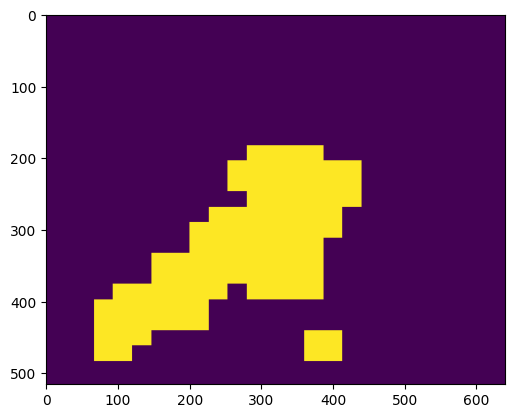

In [32]:
plt.imshow(mask) # 5

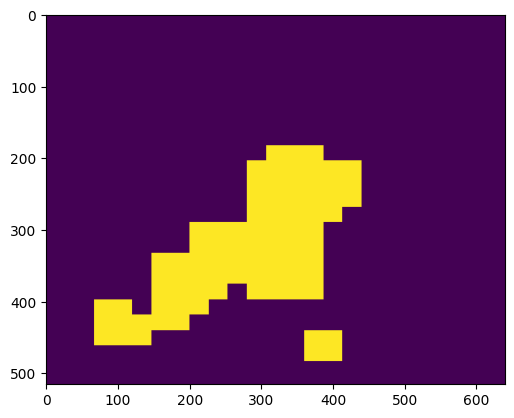

In [41]:
plt.imshow(mask) # 1

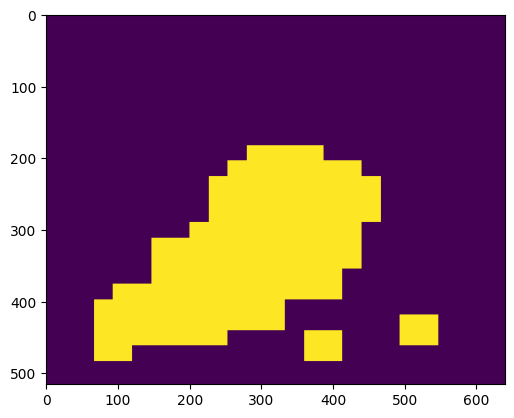

In [50]:
plt.imshow(mask) # 100

In [2]:
from pycocotools.coco import COCO

In [4]:
data_dir='/users/ujan/vlm-compositionality/data/raw/coco/'
data_type='val2017'
annFile='{}annotations/instances_{}.json'.format(data_dir,data_type)

In [5]:
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.35s)
creating index...
index created!


In [14]:
coco_ids = list(coco.anns.keys())

In [18]:
coco.anns[coco_ids[5]]

{'segmentation': [[0.0,
   503.5,
   21.89,
   490.62,
   37.34,
   467.44,
   56.66,
   455.86,
   60.52,
   448.13,
   72.11,
   439.11,
   74.69,
   432.68,
   87.57,
   421.09,
   103.02,
   422.37,
   115.9,
   430.1,
   123.62,
   437.83,
   135.21,
   440.4,
   139.07,
   449.42,
   135.21,
   454.57,
   124.91,
   467.44,
   117.18,
   467.44,
   113.32,
   475.17,
   113.32,
   491.91,
   112.03,
   500.93,
   121.05,
   491.91,
   133.92,
   491.91,
   135.21,
   485.47,
   142.94,
   485.47,
   142.94,
   491.91,
   154.53,
   490.62,
   153.24,
   504.79,
   141.65,
   508.65,
   126.2,
   522.82,
   117.18,
   536.98,
   109.46,
   546.0,
   95.29,
   540.85,
   82.41,
   543.42,
   72.11,
   556.3,
   57.95,
   571.75,
   70.82,
   591.07,
   52.8,
   621.97,
   34.77,
   629.7,
   16.74,
   628.41,
   1.29,
   627.12,
   2.58,
   513.8]],
 'area': 16932.135100000003,
 'iscrowd': 0,
 'image_id': 494869,
 'bbox': [0.0, 421.09, 154.53, 208.61],
 'category_id': 18,
 'id': 36

In [22]:
image_id = 494869
image_info = coco.loadImgs(image_id)

In [20]:
image_info

[{'license': 1,
  'file_name': '000000494869.jpg',
  'coco_url': 'http://images.cocodataset.org/val2017/000000494869.jpg',
  'height': 640,
  'width': 427,
  'date_captured': '2013-11-14 18:46:11',
  'flickr_url': 'http://farm9.staticflickr.com/8255/8713396144_ea7d431000_z.jpg',
  'id': 494869}]

In [24]:
annotation_ids = coco.getAnnIds(imgIds=image_id)

In [32]:
annotations = coco.loadAnns(annotation_ids)
cat_ids = [ann['category_id'] for ann in annotations]

In [33]:
[coco.loadCats(i)[0]['name'] for i in cat_ids]

['dog', 'person', 'spoon', 'bowl', 'bowl', 'bottle', 'bowl', 'bowl', 'person']

In [ ]:
# take images with at most one item per category